### Import Libraries

In [1]:
# Data manipulation
import pandas as pd

import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Load and Merge Data

In [2]:
# Load Data
riders = pd.read_csv("Ridewise -Project 1/riders.csv")
trips = pd.read_csv("Ridewise -Project 1/trips.csv")

In [3]:
# Convert dates
riders['signup_date'] = pd.to_datetime(riders['signup_date'], errors='coerce')
trips['pickup_time'] = pd.to_datetime(trips['pickup_time'], utc=True, errors='coerce')
trips['dropoff_time'] = pd.to_datetime(trips['dropoff_time'], utc=True, errors='coerce')


In [4]:
# Merge
data = pd.merge(trips, riders, on='user_id', how='left')

In [5]:
data.head(2)

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,weather,city_x,loyalty_status_x,signup_date,loyalty_status_y,age,city_y,avg_rating_given,churn_prob,referred_by
0,T000000,R05207,D00315,12.11,1.0,0.00,Card,2024-11-27 16:14:50+00:00,2024-11-27 17:06:50+00:00,-1.108123,...,Foggy,Nairobi,Bronze,2023-09-20,Bronze,37.629694,Nairobi,4.3,0.294348,NaN
1,T000001,R09453,D03717,8.73,1.0,0.02,Card,2024-10-28 22:59:48+00:00,2024-10-28 23:12:48+00:00,6.675266,...,Sunny,Lagos,Gold,2024-08-30,Gold,37.051088,Lagos,4.7,0.105990,R02955


In [6]:
data.tail(2)

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,weather,city_x,loyalty_status_x,signup_date,loyalty_status_y,age,city_y,avg_rating_given,churn_prob,referred_by
199998,T199998,R02867,D00974,17.18,1.3,0.0,Mobile Money,2024-09-25 02:57:33+00:00,2024-09-25 03:31:33+00:00,6.540074,...,Rainy,Lagos,Gold,2023-09-07,Gold,24.645131,Lagos,4.8,0.251196,R00665
199999,T199999,R07749,D04894,13.47,1.0,0.0,Card,2024-05-24 16:14:39+00:00,2024-05-24 16:46:39+00:00,30.234277,...,Sunny,Cairo,Bronze,2024-08-14,Bronze,34.433235,Cairo,4.1,0.324269,R07740


### Feature Engineering
#### Create Behavioral Features per user

In [7]:
# Create Trip Duration
data['trip_duration'] = (data['dropoff_time'] - data['pickup_time']).dt.total_seconds() / 60

In [8]:
# Aggregate to User Level
user_features = data.groupby('user_id').agg({
    'trip_id': 'count','fare': 'sum','trip_duration': 'mean','surge_multiplier': 'mean','tip': 'sum','pickup_time': 'max'
}).reset_index()

#### Rename columns:

In [9]:
user_features.columns = ['user_id','total_trips','total_spent','avg_trip_duration','avg_surge','total_tip',
    'last_trip_date']

#### Create Churn Label
##### We define churn as :No trip in last 30 days

In [10]:
reference_date = data['pickup_time'].max()

user_features['days_since_last_trip'] = (
    reference_date - user_features['last_trip_date']
).dt.days

user_features['churn'] = np.where(
    user_features['days_since_last_trip'] > 30,
    1, 0
)

In [11]:
user_features['churn'].value_counts()
# (days_since_last_trip > 30	1	(Churned)
# (days_since_last_trip ≤ 30	0	Active (Not churned)
# 1 = churned customer
# 0 = active customer

churn
0    8114
1    1886
Name: count, dtype: int64

#### Calculate Churn Rate 

##### Churn Interpretation

##### 8,114 users are active

##### 1,886 users are churned

##### Total users = 10,000


In [12]:
# Calculate churn rate
churn_rate = user_features['churn'].mean()
print("Churn Rate:", round(churn_rate * 100, 2), "%")

Churn Rate: 18.86 %


#### Churn Label Definition

##### Customers were classified as churned (1) if they had no trip activity in the last 30 days from the reference date. Customers active within 30 days were classified as non-churned (0).
##### The dataset shows an approximate churn rate of 18.9%, indicating moderate class imbalance.

### Supervised ML

In [13]:
features = ['total_trips','total_spent','avg_trip_duration','avg_surge','total_tip','days_since_last_trip']

In [14]:
X = user_features[features]
y = user_features['churn']

#### Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.2,random_state=42,stratify=y)

#### Scale Features

In [16]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Initial Logistic Regression Model

In [17]:
log_model = LogisticRegression()

log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_pred_log))

Logistic Regression Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1623
           1       1.00      1.00      1.00       377

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 1.0


#### Initial Random Forest Model

In [18]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))

Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1623
           1       1.00      1.00      1.00       377

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 1.0


#### Data Leakage Identification and Correction

##### The initial Logistic Regression and Random Forest models achieved perfect performance metrics (accuracy and ROC AUC = 1.0). While this appeared highly impressive, such results are unrealistic in real-world churn prediction problems and indicated the presence of data leakage.

##### Further investigation revealed that the feature days_since_last_trip was used to define the churn target variable and was also included as an input feature during model training. This allowed the models to indirectly access target information, leading to artificially inflated performance.

##### To ensure proper model evaluation and realistic predictive performance, the leaked feature was removed from the feature set. Both models were subsequently retrained using only independent behavioral features.

##### The following section presents the corrected models and their revised performance results.

#### Re-Modelling 

In [19]:
# Revised Feature List
features = ['total_trips','total_spent','avg_trip_duration','avg_surge','total_tip'
]

In [20]:
# Rebuild X and y
X = user_features[features]
y = user_features['churn']

In [21]:
# Re-run Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y)

In [22]:
# Re-scale (for Logistic Regression only)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Re-run Logistic Regression
log_model = LogisticRegression()

log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_pred_log))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1623
           1       0.00      0.00      0.00       377

    accuracy                           0.81      2000
   macro avg       0.41      0.50      0.45      2000
weighted avg       0.66      0.81      0.73      2000

ROC AUC: 0.5


In [24]:
# Re-run Random Forest
# N/B: use X_train and X_test without scaling
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))

Random Forest Results
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1623
           1       0.33      0.03      0.05       377

    accuracy                           0.81      2000
   macro avg       0.57      0.51      0.47      2000
weighted avg       0.72      0.81      0.73      2000

ROC AUC: 0.5071011700178633


#### Corrected Model Performance Analysis

##### After removing data leakage, both Logistic Regression and Random Forest models showed significantly reduced performance.

##### Logistic Regression achieved an accuracy of 81% but failed to correctly identify churned users, resulting in a recall of 0.00 for the churn class and an ROC AUC score of 0.50. This indicates that the model performed no better than random classification.

##### Random Forest showed slightly improved performance with a churn recall of 0.03 and an ROC AUC score of approximately 0.51. However, it still struggled to effectively detect churned customers.

##### The results suggest that the current feature set lacks sufficient predictive power to accurately distinguish between churned and active users. Additionally, class imbalance contributed to the models’ tendency to favor the majority (non-churn) class.

##### Future improvements may include additional feature engineering, class imbalance handling techniques, and incorporation of temporal and behavioral trend features.

In [25]:
from sklearn.model_selection import train_test_split

X = user_features[features]
y = user_features['churn']

In [26]:
# Define Feature
features = ['total_trips','total_spent','avg_trip_duration','avg_surge','total_tip']

In [27]:
# Create X and y
X = user_features[features]
y = user_features['churn']

In [28]:
# Import and Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42,stratify=y)

In [29]:
# Train Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced')

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

### Random Forest Built-in Feature Importance (Bar Chart)

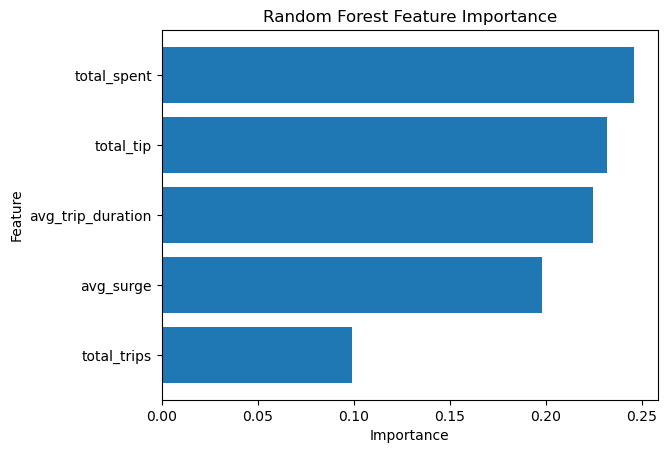

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)

plt.figure()
plt.barh(importances.index, importances.values)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Random Forest Feature Importance Analysis

##### The Random Forest model identified total_spent as the most influential predictor of churn, followed by total_tip and avg_trip_duration. This indicates that customer monetary value and engagement behavior are stronger predictors of churn than simple trip frequency.

##### Interestingly, total_trips contributed the least to predictive performance, suggesting that cumulative spending and behavioral patterns are more informative than raw activity counts.

##### These findings highlight the importance of focusing retention strategies on high-value behavioral indicators rather than solely on trip frequency.

### Permutation Importance (More reliable than built-in)

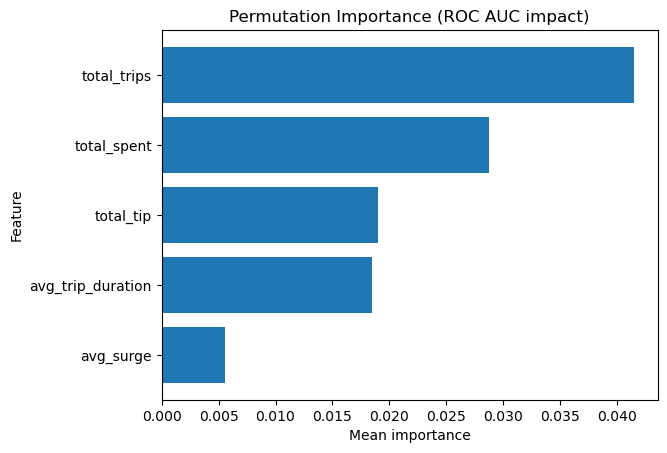

In [34]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(rf_model, X_test, y_test,n_repeats=10,random_state=42,scoring='roc_auc')

perm_importances = pd.Series(perm.importances_mean, index=features).sort_values(ascending=True)

plt.figure()
plt.barh(perm_importances.index, perm_importances.values)
plt.title("Permutation Importance (ROC AUC impact)")
plt.xlabel("Mean importance")
plt.ylabel("Feature")
plt.show()

### Permutation Feature Importance Analysis

##### Permutation importance was used to evaluate the impact of each feature on model performance by measuring changes in ROC AUC after feature shuffling.

##### The results indicate that total_trips is the most influential predictor of churn, followed by total_spent and total_tip. This suggests that customer engagement frequency plays a more critical role in churn prediction than monetary value alone.

##### Compared to the built-in Random Forest importance, permutation importance provides a more reliable assessment of feature relevance, as it directly measures the effect of each feature on predictive performance.